In [10]:

import pandas as pd

df = pd.read_csv("../data/anime.csv")

In [11]:
#----GENERAL----
import numpy as np

df['genre_count'] = df['genre'].str.count(',') + 1

df['log_members'] = np.log1p(df['members'])
df.head()




,anime_id,name,genre,type,episodes,rating,members,genre_count,log_members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,4.0,12.209223
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,7.0,13.584418
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,7.0,11.646258
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,2.0,13.420352
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,7.0,11.926802


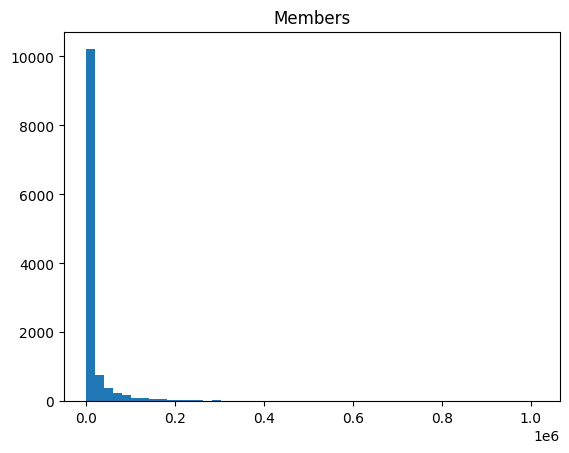

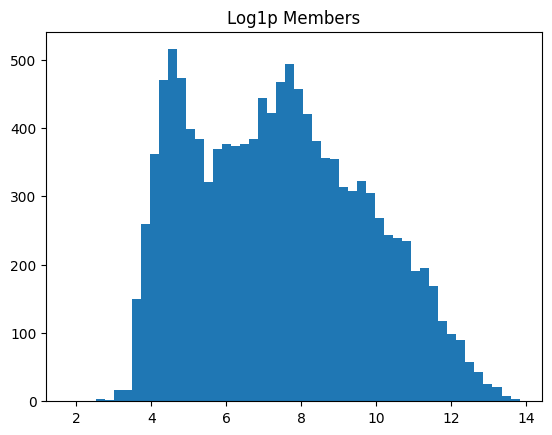

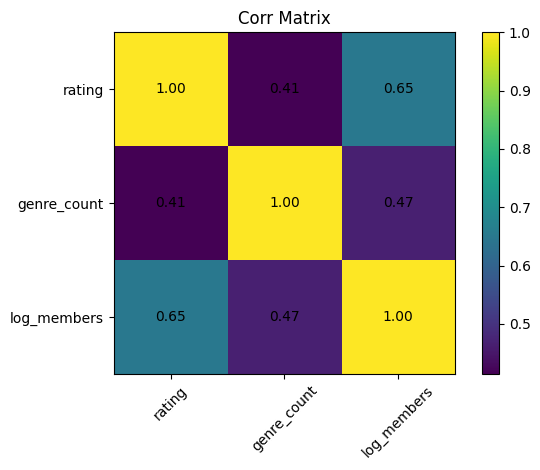

In [12]:
#---EDA PLOTS---
import matplotlib.pyplot as plt

plt.figure(); plt.hist(df['members'], bins=50); plt.title('Members'); plt.show()
plt.figure(); plt.hist(df['log_members'], bins=50); plt.title('Log1p Members'); plt.show()


corr = df[['rating','genre_count','log_members']].corr()
plt.figure(); plt.imshow(corr, interpolation='nearest'); plt.colorbar(); 
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j,i,f"{corr.iloc[i,j]:.2f}",ha='center',va='center')
plt.title('Corr Matrix'); plt.tight_layout(); plt.show()


In [ ]:
# ---REGRESSION COMPARISON---
import numpy as np
import pandas as pd
from sklearn.preprocessing   import MultiLabelBinarizer
from sklearn.model_selection  import train_test_split, cross_val_score
from sklearn.linear_model     import LinearRegression, Ridge, Lasso
from sklearn.ensemble         import RandomForestRegressor
from sklearn.metrics          import mean_squared_error, mean_absolute_error, r2_score

df['genre_count'] = df['genre'].str.count(',') + 1
df['log_members']  = np.log1p(df['members'])

genre_lists = df['genre'].str.split(',').apply(lambda L: [g.strip() for g in L])
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(
    mlb.fit_transform(genre_lists),
    columns=mlb.classes_,
    index=df.index
)

X = pd.concat([df[['genre_count','log_members']], genre_dummies], axis=1)
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Drop rows where any feature or the target is NaN
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#define models to campare 
models = [
    ("LinearReg", LinearRegression()),
    ("Ridge α=1",  Ridge(alpha=1.0)),
    ("Lasso α=0.1", Lasso(alpha=0.1, max_iter=10000)),
    ("RFReg",      RandomForestRegressor(n_estimators=100, random_state=42))
]

# 4) Fit & Evaluate
results = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2" : r2_score(y_test, y_pred),
        "CV_R2 (5-fold)": np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="r2"))
    })

metrics_df = pd.DataFrame(results).set_index("Model")
print(metrics_df)



                  MSE       MAE        R2  CV_R2 (5-fold)
Model                                                    
LinearReg    0.549123  0.539222  0.474348        0.516458
Ridge α=1    0.549059  0.539147  0.474409        0.516497
Lasso α=0.1  0.625810  0.578864  0.400939        0.441001
RFReg        0.561220  0.536682  0.462768        0.489565
